In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the data
ppi_clean = pd.read_csv('data/ppi_clean.csv')
ppi_clean

,domain,aa_ProtPosition,uniprot_id,hydrophobicity_scores,Rlength,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,prob_sheet,...,9_wm_pssm_K,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface
0,0,1,A0A024RAV5,0.64,188,0.238095,0.784319,0.711111,0.803,0.003,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
1,0,2,A0A024RAV5,-0.05,188,0.238095,0.359207,0.422222,0.530,0.047,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
2,0,3,A0A024RAV5,-0.74,188,0.238095,0.395387,0.111111,0.464,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
3,0,4,A0A024RAV5,0.26,188,0.238095,0.401655,0.355556,0.385,0.084,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
4,1,5,A0A024RAV5,-1.50,188,0.238095,0.288103,0.066667,0.287,0.084,...,0.302858,0.436017,0.238759,0.103980,0.105653,0.161544,0.060391,0.140326,0.481904,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65145,1,34,P0A427,1.38,38,0.014881,0.210794,1.000000,0.233,0.086,...,0.286923,0.374128,0.415754,0.109332,0.351726,0.330383,0.241807,0.334863,0.381730,1
65146,0,35,P0A427,-0.74,38,0.014881,0.292872,0.111111,0.343,0.086,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
65147,0,36,P0A427,0.48,38,0.014881,0.141193,0.455556,0.367,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
65148,0,37,P0A427,-0.74,38,0.014881,0.406473,0.111111,0.477,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1


In [3]:
# Remove columns that shouldn't be features
def remove_non_features(df: pd.DataFrame, non_feature_cols: list[str]) -> pd.DataFrame:
    return df.drop(non_feature_cols, axis=1)

In [4]:
# Split data into train/validation and test set, taking into account the protein groups
from sklearn.model_selection import GroupShuffleSplit

def split_data_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, **kwargs) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    gss = GroupShuffleSplit(**kwargs)

    for train_idx, test_idx in gss.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    assert set(X_train.uniprot_id).intersection(set(X_test.uniprot_id)) == set(), 'The same uniprot ID appears in both the train and test set!'
    return X_train, X_test, y_train, y_test

def select_window_size(df: pd.DataFrame, window_size: int) -> pd.DataFrame:
    '''Remove the window columns that are not used, i.e. not specified in window_size'''
    wm_cols = df.columns[df.columns.str.match(r"^\d+_wm")].tolist()  # Regex for [number]_wm
    pssm_cols = [col for col in df.columns if col.startswith('pssm') or col.startswith('prob')]
    extra_cols = ['rel_surf_acc', 'normalized_abs_surf_acc', 'normalized_hydropathy_index']
    all_cols = set(wm_cols + pssm_cols + extra_cols)
    if window_size != 1:
        keep_cols = set([col for col in df.columns if col.startswith(f"{window_size}_wm")])
        cols_to_remove = list(set(all_cols).difference(set(keep_cols)))

    else:
        cols_to_remove = wm_cols
    cols_before = frozenset(df.columns)
    df = df.drop(cols_to_remove, axis=1)
    cols_after = frozenset(df.columns)
    print('Intersection: ', cols_before.intersection(cols_after))

    return df

ppi_clean_9 = select_window_size(ppi_clean, 9)

X = ppi_clean_9.drop('p_interface', axis=1)
y = ppi_clean_9.p_interface
groups = ppi_clean.uniprot_id

X_tv, X_test, y_tv, y_test = split_data_by_group(X, y, groups, train_size=0.2)

Intersection:  frozenset({'hydrophobicity_scores', '9_wm_pssm_S', '9_wm_pssm_E', '9_wm_pssm_V', 'normalized_length', '9_wm_pssm_T', '9_wm_pssm_I', 'Rlength', '9_wm_pssm_K', '9_wm_rel_surf_acc', 'aa_ProtPosition', '9_wm_prob_helix', '9_wm_pssm_H', '9_wm_pssm_A', '9_wm_pssm_R', '9_wm_pssm_C', '9_wm_pssm_Q', '9_wm_pssm_L', 'uniprot_id', '9_wm_pssm_D', '9_wm_normalized_hydropathy_index', '9_wm_pssm_F', 'p_interface', '9_wm_prob_coil', '9_wm_normalized_abs_surf_acc', '9_wm_pssm_W', '9_wm_prob_sheet', '9_wm_pssm_G', '9_wm_pssm_M', '9_wm_pssm_N', 'domain', '9_wm_pssm_P', '9_wm_pssm_Y'})


Performing on fold=0
[1023, 10684, 289, 2627]
Performing on fold=1
[1023, 10684, 289, 2627, 1140, 10558, 172, 2753]
Performing on fold=2
[1023, 10684, 289, 2627, 1140, 10558, 172, 2753, 1022, 10651, 290, 2660]
Performing on fold=3
[1023, 10684, 289, 2627, 1140, 10558, 172, 2753, 1022, 10651, 290, 2660, 1024, 10648, 288, 2663]
Performing on fold=4
[1023, 10684, 289, 2627, 1140, 10558, 172, 2753, 1022, 10651, 290, 2660, 1024, 10648, 288, 2663, 1039, 10703, 273, 2608]


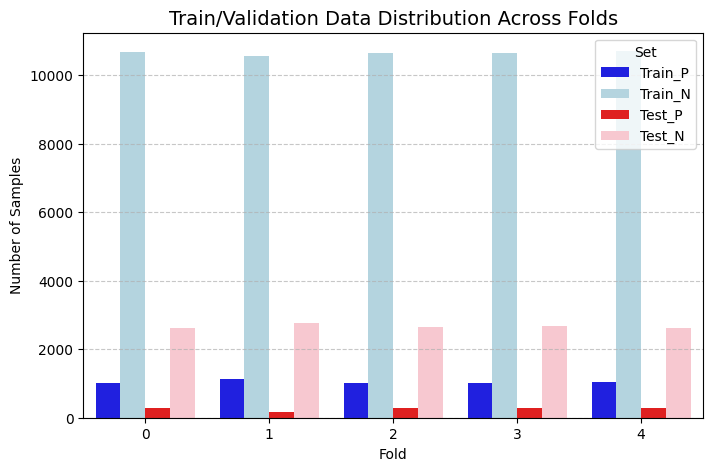

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, recall_score

def kfold_cv_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, model: BaseEstimator, **kwargs) -> pd.DataFrame:
    group_kfold = GroupKFold(**kwargs)

    scores = {'fold': [], 'auc': [], 'rec': []}
    fold_data = {'Fold': [], 'Set': [], 'Size': []}

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
        print(f'Performing on {fold=}')
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        auc_score = roc_auc_score(y_val, y_pred)
        rec_score = recall_score(y_val, y_pred)
        
        scores['fold'].append(fold)
        scores['auc'].append(auc_score)
        scores['rec'].append(rec_score)  # TPR

        fold_data['Fold'].extend([fold, fold, fold, fold])  # Add fold index twice
        fold_data['Set'].extend(['Train_P', 'Train_N', 'Test_P', 'Test_N'])  # Train and Test labels
        fold_data['Size'].extend([len(y_train[y_train == 1]), len(y_train[y_train == 0]), 
                                  len(y_val[y_val == 1]), len(y_val[y_val == 0])])  # Number of samples
        print(fold_data['Size'])
    
    # Convert to DataFrame
    fold_df = pd.DataFrame(fold_data)

    # Create bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=fold_df, x="Fold", y="Size", hue="Set", palette=['blue', 'lightblue', 'red', 'pink'], dodge='auto')

    # Customize plot
    plt.title("Train/Validation Data Distribution Across Folds", fontsize=14)
    plt.xlabel("Fold")
    plt.ylabel("Number of Samples")
    plt.legend(title="Set", loc="upper right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return pd.DataFrame(scores)

non_feature_cols = ['domain', 'aa_ProtPosition', 'uniprot_id']
X = remove_non_features(X_tv, non_feature_cols)
y = y_tv
groups = X_tv.uniprot_id

baseline_model = DecisionTreeClassifier(class_weight='balanced')

baseline_scores = kfold_cv_by_group(X, y, groups, baseline_model)

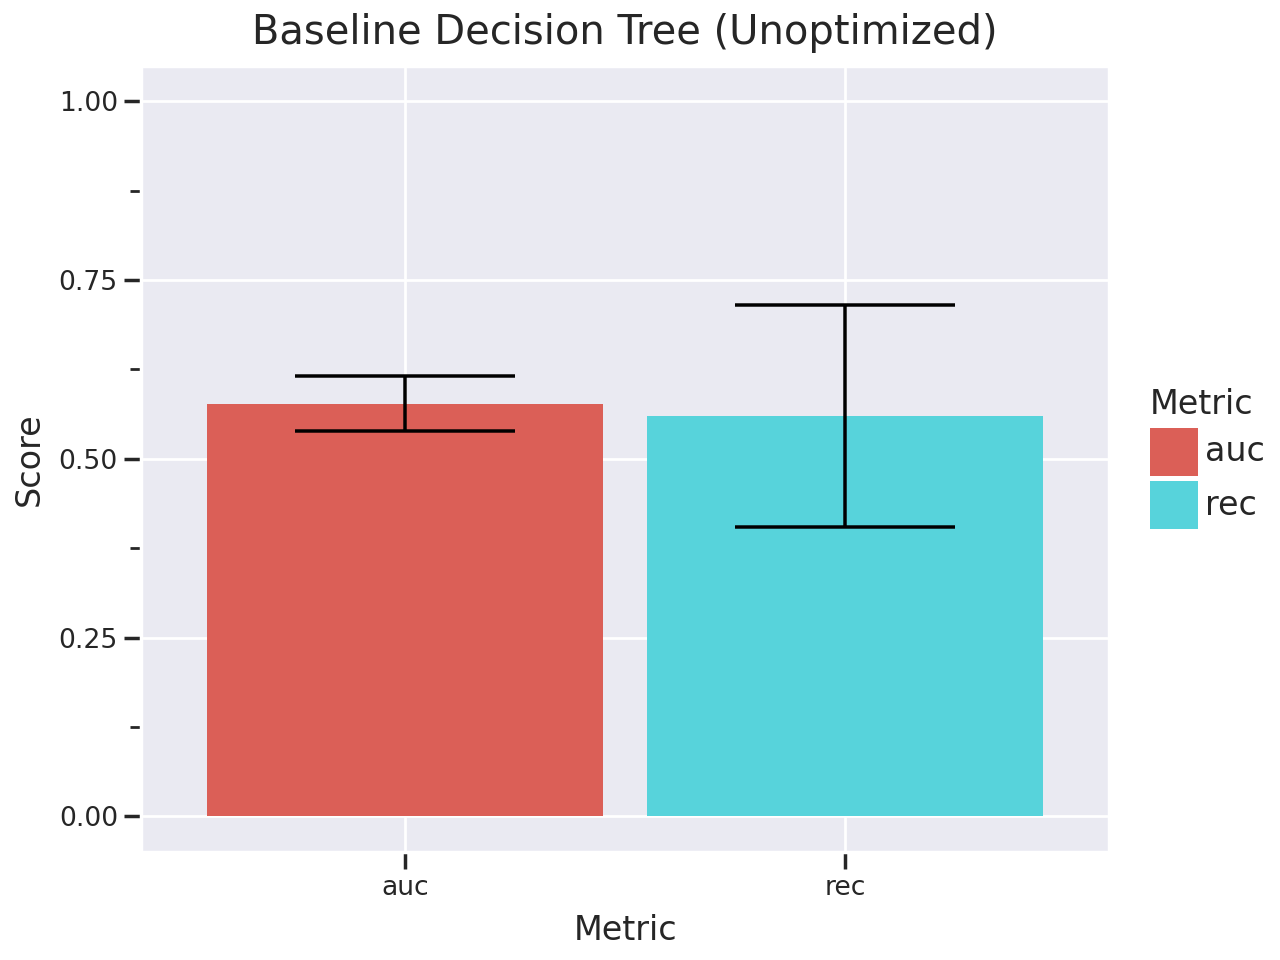

In [17]:
from plotnine import ggplot, aes, geom_bar, geom_errorbar, labs, theme_seaborn, ylim

def plot_performance(df: pd.DataFrame, score_names: list, title: str='') -> None:

    df_long = df.melt(value_vars=['auc', 'rec'], var_name='Metric', value_name='Score')
    score_means = df[score_names].mean()
    score_stds = df[score_names].std()
    score_summary = pd.DataFrame({
        'Metric': score_means.index,
        'Mean': score_means.values,
        'StDev': score_stds.values
    })
    df_long = df_long.merge(score_summary, on='Metric', how='left')

    # Create ggplot
    p = (
        ggplot(df_long, aes(x='Metric', y='Mean', fill='Metric')) +
        geom_bar(stat='identity', position='dodge', show_legend=True) +  # Bar plot
        labs(title=title, y="Score", x="Metric") +
        geom_errorbar(aes(ymin='Mean - StDev', ymax='Mean + StDev')) +
        ylim(0,1) +
        theme_seaborn()
    )

    display(p)

plot_performance(baseline_scores, ['auc', 'rec'], 'Baseline Decision Tree (Unoptimized)')

In [ ]:
from sklearn.model_selection import GridSearchCV
# Grid search optimization
gs_params = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 7, 10, 12, 15, 20],
    'min_samples_leaf': [4, 8, 12, 14, 16, 18, 20, 24, 32]
}  # min_samples_split was omitted because it didn't have a big impact on performance
gs_model = DecisionTreeClassifier(class_weight='balanced')
gridsearch = GridSearchCV(gs_model, param_grid=gs_params, n_jobs=-1, scoring='roc_auc', cv=GroupKFold())

gridsearch.fit(X, y, groups=groups)
print(gridsearch.best_params_, 'with score: ', gridsearch.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20} with score:  0.6258255221960558


In [14]:
pd.DataFrame(gridsearch.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
60,0.385770,0.027699,0.006396,0.001370,entropy,5,20,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.672582,0.585414,0.564356,0.575998,0.730778,0.625826,0.064954,1
8,0.291127,0.013758,0.005801,0.001166,gini,5,32,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.669240,0.615635,0.551987,0.560132,0.729686,0.625336,0.067145,2
56,0.370307,0.023034,0.006139,0.001635,entropy,5,12,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.667023,0.585280,0.567231,0.572951,0.733066,0.625110,0.064912,3
58,0.431927,0.073866,0.012996,0.006422,entropy,5,16,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.665081,0.585280,0.567042,0.575998,0.731028,0.624886,0.063539,4
112,0.365674,0.028258,0.005135,0.000539,log_loss,5,16,"{'criterion': 'log_loss', 'max_depth': 5, 'min...",0.664143,0.585280,0.567042,0.575998,0.731060,0.624705,0.063433,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.883532,0.077240,0.005895,0.000793,entropy,20,12,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.536370,0.496475,0.509958,0.508072,0.477118,0.505599,0.019320,158
144,0.959344,0.073552,0.007113,0.002098,log_loss,15,4,"{'criterion': 'log_loss', 'max_depth': 15, 'mi...",0.502357,0.460663,0.528159,0.501450,0.482847,0.495095,0.022458,159
90,0.818295,0.041353,0.005274,0.000404,entropy,15,4,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.491440,0.466476,0.525371,0.500696,0.487867,0.494370,0.019131,160
99,0.941831,0.083622,0.006226,0.001829,entropy,20,4,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.510664,0.462608,0.501222,0.486061,0.491011,0.490313,0.016244,161


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20}
Performing on fold=0
[1023, 10684, 289, 2627]
Performing on fold=1
[1023, 10684, 289, 2627, 1140, 10558, 172, 2753]
Performing on fold=2
[1023, 10684, 289, 2627, 1140, 10558, 172, 2753, 1022, 10651, 290, 2660]
Performing on fold=3
[1023, 10684, 289, 2627, 1140, 10558, 172, 2753, 1022, 10651, 290, 2660, 1024, 10648, 288, 2663]
Performing on fold=4
[1023, 10684, 289, 2627, 1140, 10558, 172, 2753, 1022, 10651, 290, 2660, 1024, 10648, 288, 2663, 1039, 10703, 273, 2608]


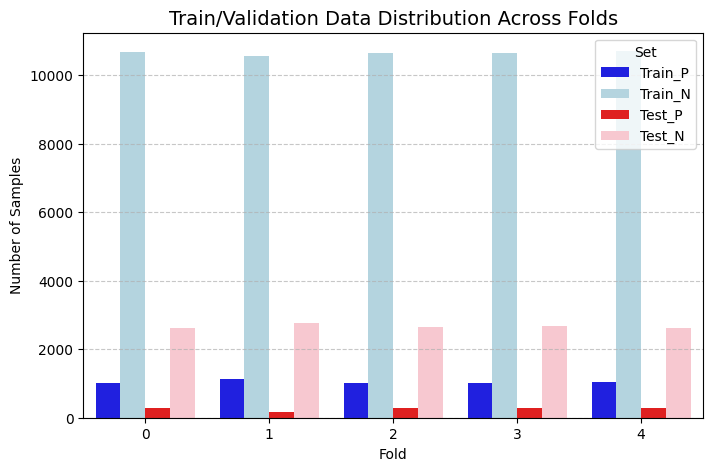

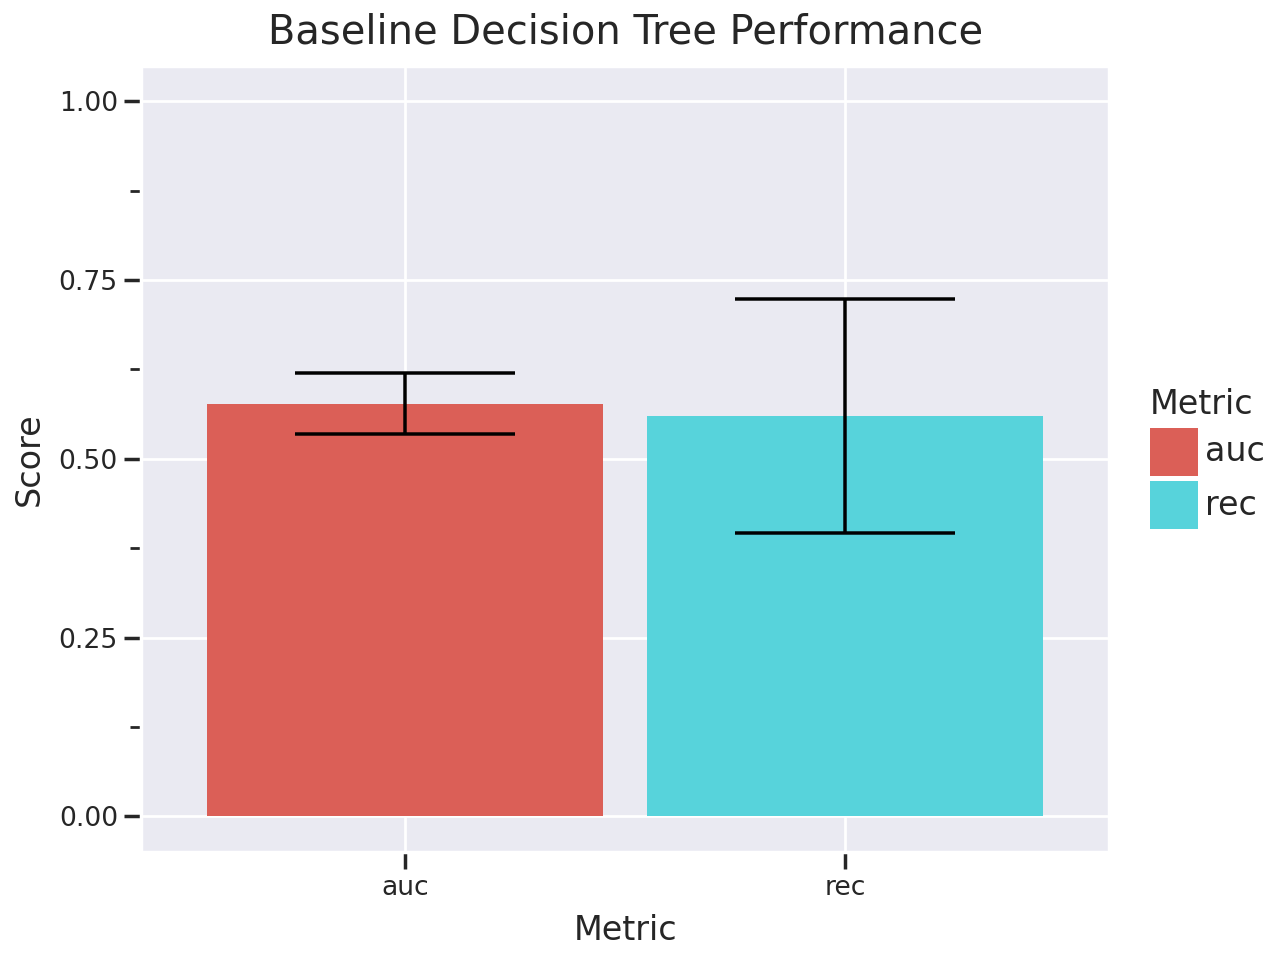

In [19]:
# Train optimized DT
baseline_model = DecisionTreeClassifier(class_weight='balanced', **gridsearch.best_params_)
print(gridsearch.best_params_)

baseline_scores = kfold_cv_by_group(X, y, groups, baseline_model)

plot_performance(baseline_scores, ['auc', 'rec'], 'Baseline Decision Tree Performance')